# Predicting prices on housing market in Melbourne - Capstone Project
## Part 2: Initial data analysis

In [0]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [2]:
# reading in csv file
df = pd.read_csv('data_cleansed.csv')
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname
0,Abbotsford,85 Turner St,2.0,h,1480000.0,S,BIGGIN,2016-03-12,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan
1,Abbotsford,25 Bloomburg St,2.0,h,1035000.0,S,BIGGIN,2016-04-02,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan
2,Abbotsford,5 Charles St,3.0,h,1465000.0,SP,BIGGIN,2017-04-03,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan
3,Abbotsford,40 Federation La,3.0,h,850000.0,PI,BIGGIN,2017-04-03,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan
4,Abbotsford,55a Park St,4.0,h,1600000.0,VB,NELSON,2016-04-06,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan


### Initial data analysis
Finally, after the data is cleansed, I can get familiar with it. I am going to look for correlation with the target variable to get some insights on how to construct a prediction model. But first, let's again check the price distribution.

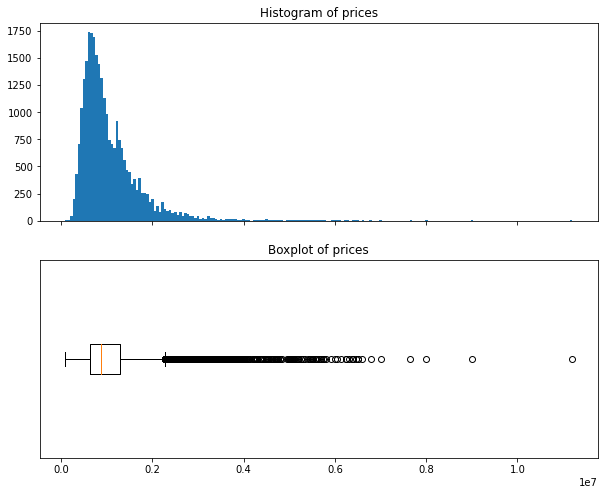

In [0]:
# plotting histograms of some numerical variables
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))
axs = axes.flatten()

axs[0].hist(df['Price'], bins=200)
axs[0].set_title('Histogram of prices')

axs[1].boxplot(df['Price'], vert=False)
axs[1].set_title('Boxplot of prices')
axs[1].set_yticks([])
plt.show()

Price distibution is positively skewed - most of the prices are higher than mean. There are many outliers in the dataset, also the distribution is not normal. Whiskers are not equal size and median is closer to first quartile than the third. 

In the next step, I want to see how prices were changing over time.

In [0]:
# preparing daily statistics
mean_date_price = df.groupby('Date')['Price'].mean()
median_date_price = df.groupby('Date')['Price'].median()
max_date_price = df.groupby('Date')['Price'].max()
min_date_price = df.groupby('Date')['Price'].min()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: MaxNLocator.set_params got an unexpected parameter: numticks
  after removing the cwd from sys.path.


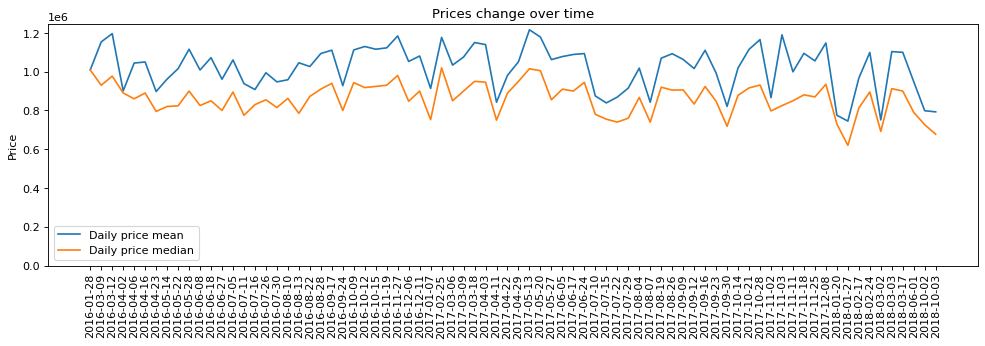

In [10]:
# plotting median and mean daily prices
plt.figure(figsize=(15, 4), dpi= 80)
plt.plot(mean_date_price.keys(), mean_date_price)
plt.plot(median_date_price.keys(), median_date_price)

plt.title('Prices change over time')
plt.xticks(rotation=90)
plt.ylabel('Price')
plt.ylim(ymin=0)
plt.legend(['Daily price mean', 'Daily price median'])

plt.show()

Prices were changing rapidly, but usually direction of the change was similar for mean and median. Mean is obviously higher, affected by outliers. I can see some tendency of hitting the minimum around turn of the year. For the first two years there might be some pattern in those highs and lows, but for last half a year there is a smooth decrease of prices. Nonetheless, it is a good discovery - time is an important factor for price modeling. 

What about monthly prices?

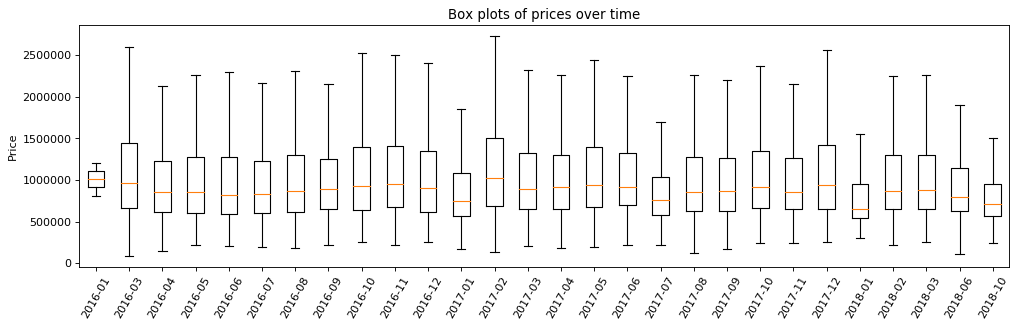

In [0]:
# creating helper column
df['year_month'] = [datetime.strftime(i, '%Y-%m') for i in df['Date']]

price_by_month = [df.query("year_month == '{}'".format(month))['Price'] for month in df.year_month.sort_values().unique()]
plt.figure(figsize=(15, 4), dpi= 80)
plt.boxplot(price_by_month, sym='')
plt.ylabel('Price')
plt.xticks([i+1 for i in range(df.year_month.nunique())], list(df.year_month.sort_values().unique()), rotation=60)
plt.title('Box plots of prices over time')
plt.show()

Now I want to see how many offers were given daily over time.

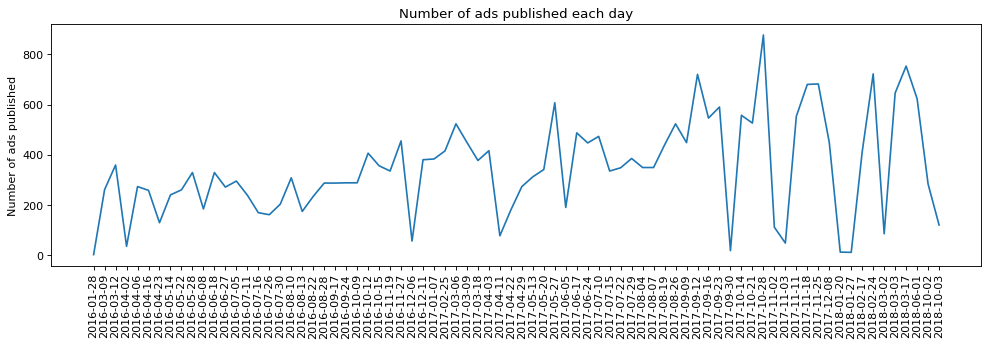

In [35]:
# preparing data
ad_count = df['Date'].value_counts().sort_index()

# plotting number of ads published a day
plt.figure(figsize=(15,4), dpi=80)
plt.plot(ad_count.index, ad_count.values)
plt.title('Number of ads published each day')
plt.xticks(rotation=90)
plt.ylabel('Number of ads published')
plt.show()

Number of published offers was changing all the time. It is really hard to find some trend.

Now, let's check correlations for numeric variables.

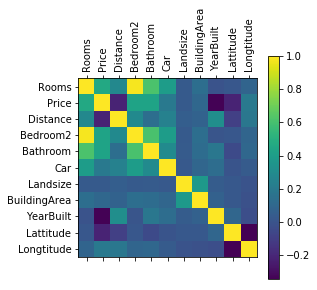

In [0]:
# getting numeric-only columns
df_nums = df.select_dtypes(include=['float64'])

# plotting correlations
plt.matshow(df_nums.corr())
plt.xticks([i for i in range(df_nums.shape[1])], list(df_nums.columns))
plt.yticks([i for i in range(df_nums.shape[1])], list(df_nums.columns))
plt.colorbar()
plt.xticks(rotation=90)
plt.show()

Even thought at first I was not able to see any correlation between rooms in the house, it indeed exists. There is very high positive correlation between number of rooms, bedrooms and bathrooms. However, what is the most essencial for this analysis, price is strongly correlated with those variables. There is also some correlation with car and longitude of location, and negative correlation with distance from the city centre, which seems plausible.

Let's see histograms of those columns.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


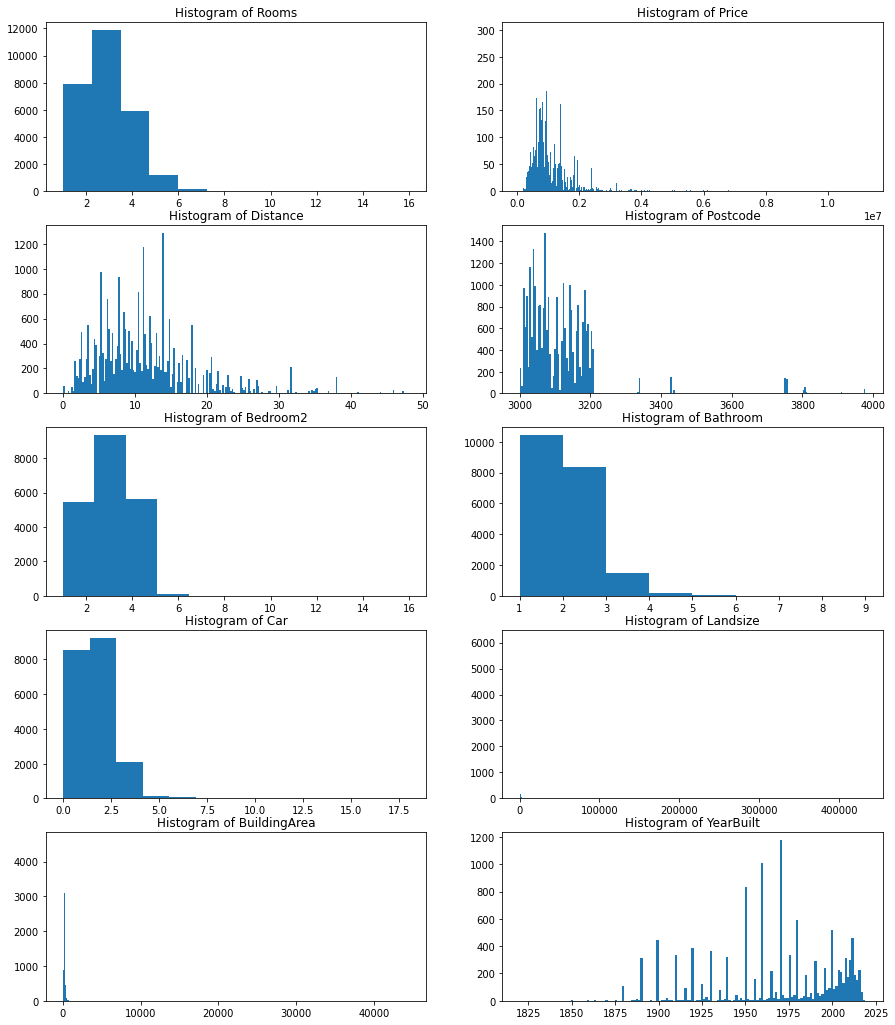

In [39]:
# plotting histograms of some numerical variables
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,18))
axs = axes.flatten()

cols = [df[col] for col in df.select_dtypes(exclude=['object', 'datetime']).columns[:-2]]

bins = [i.nunique() for i in cols]

for n in range(0, len(axs)):
    axs[n].hist(cols[n], bins=bins[n])
    axs[n].set_title('Histogram of {}'.format(cols[n].name))
plt.show()

And now let's begin to familiarize with non-numeric variables.

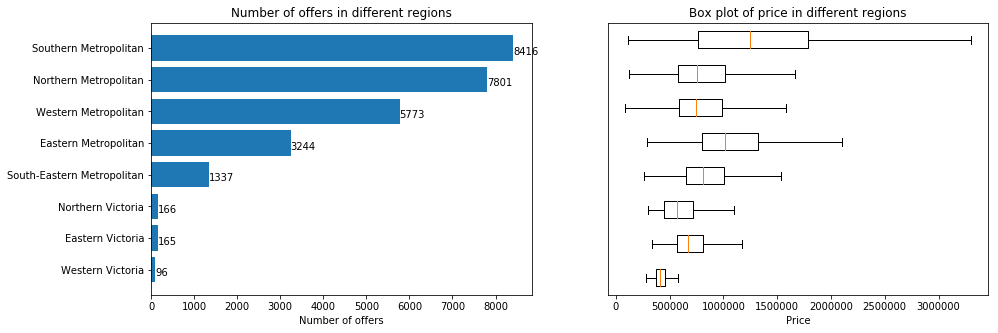

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs = axes.flatten()

# plotting number of offers in regions
region_count = df.groupby('Regionname').size().sort_values()
locations = [i for i in range(len(region_count))]
heights = [i for i in region_count]
labels = list(region_count.index)

axs[0].barh(locations, heights, tick_label=labels)
axs[0].set_title('Number of offers in different regions')
axs[0].set_xlabel('Number of offers')
for i in locations:
    axs[0].annotate(heights[i], (heights[i], i-0.2))

# plotting distribution of price in regions
price_by_reg = [df.query("Regionname == '{}'".format(reg))['Price'] for reg in list(region_count.index)]

axs[1].boxplot(price_by_reg, vert=False, sym='')
axs[1].set_xlabel('Price')
axs[1].set_yticks([])
axs[1].set_title('Box plot of price in different regions')

plt.show()

The region with the biggest number of offers is Southern Metropolitan, prices there are the most diversified, but median is the highest. In general, regions seem to differentiate prices. 

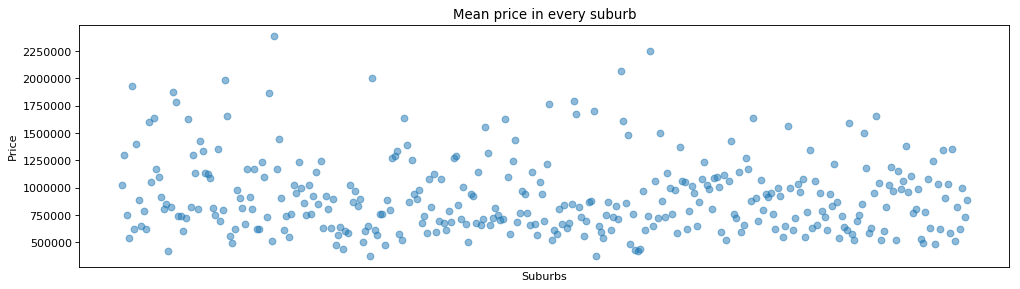

In [0]:
# plotting mean price in a suburb
price_by_suburb = df.groupby('Suburb')['Price'].mean()

plt.figure(figsize=(15,4), dpi=80)
plt.scatter(price_by_suburb.index, price_by_suburb.values, alpha=0.5)
plt.title('Mean price in every suburb')
plt.ylabel('Price')
plt.xlabel('Suburbs')
plt.xticks([])
plt.show()

The are over 300 various suburbs, so creating a box plot to analyse price distribution based on suburb is difficult. To get any clue, I prepared a plot of mean price in every suburb. Most of them is described by mean less than 1 000 000, but for some the statistic is much higher. It indicates that prices indeed differ depending on suburb.

Address will not be analysed - this column consists of many differing inputs, so it won't be useful for model. I am dropping the column.

In [0]:
# dropping the column
df = df.drop(columns=['Address'])

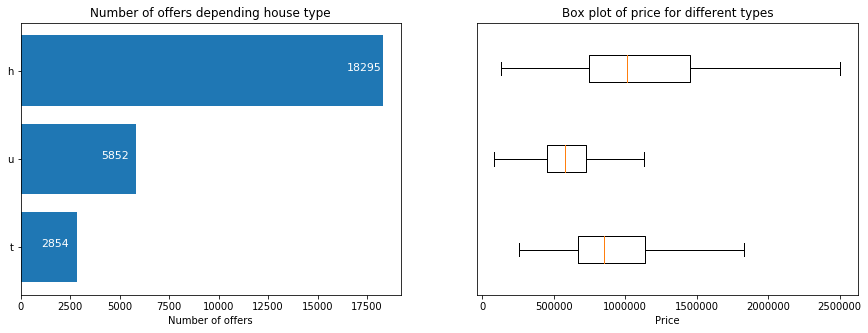

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs = axes.flatten()

# plotting number of offers in regions
type_count = df.groupby('Type').size().sort_values()
locations = [i for i in range(len(type_count))]
heights = [i for i in type_count]
labels = list(type_count.index)

axs[0].barh(locations, heights, tick_label=labels)
axs[0].set_title('Number of offers depending house type')
axs[0].set_xlabel('Number of offers')
for i in locations:
    axs[0].annotate(heights[i], (heights[i]-1800, i), color='white', size=11)

# plotting distribution of price in regions
price_by_type = [df.query("Type == '{}'".format(t))['Price'] for t in list(type_count.index)]

axs[1].boxplot(price_by_type, vert=False, sym='')
axs[1].set_xlabel('Price')
axs[1].set_yticks([])
axs[1].set_title('Box plot of price for different types')

plt.show()

Type will be crucial while modelling - it is clear that on average houses are the most expensive and units are the cheapest. Also houses are the most popular and least popular are townhouses.

In [0]:
df = df.drop(columns=['Method'])

Next variable is Method, which explains how property was sold. Before the action of selling nobody can be sure which method will be used, so it shouldn't be used as a model feature. I am dropping the column.

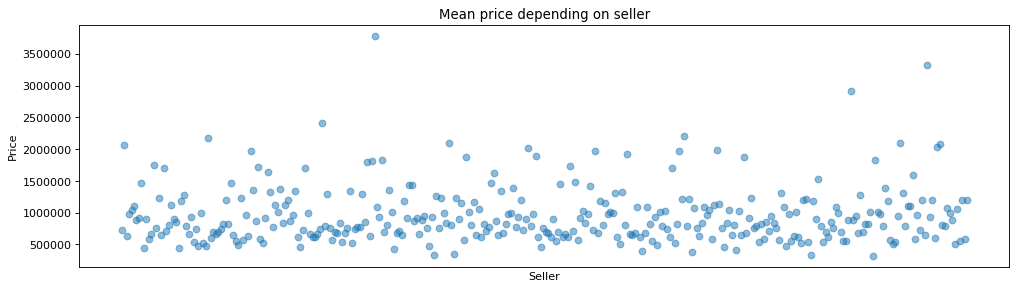

In [0]:
# plotting mean price for each seller
price_by_seller = df.groupby('SellerG')['Price'].mean()

plt.figure(figsize=(15,4), dpi=80)
plt.scatter(price_by_seller.index, price_by_seller.values, alpha=0.5)
plt.title('Mean price depending on seller')
plt.ylabel('Price')
plt.xlabel('Seller')
plt.xticks([])
plt.show()

There is some differentiation, but it is not as considerable as for suburbs. I am leaving this variable in a dataframe, but I do not expect it to be very influantial.

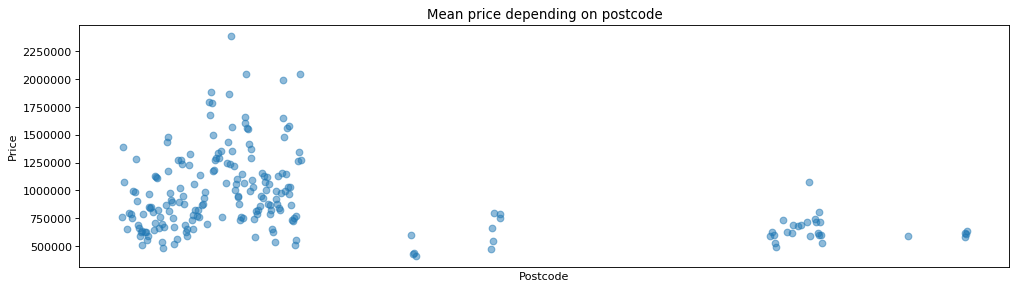

In [0]:
# plotting mean price for each seller
price_by_postcode = df.groupby('Postcode')['Price'].mean()

plt.figure(figsize=(15,4), dpi=80)
plt.scatter(price_by_postcode.index, price_by_postcode.values, alpha=0.5)
plt.title('Mean price depending on postcode')
plt.ylabel('Price')
plt.xlabel('Postcode')
plt.xticks([])
plt.show()

Prices seem to differ based on postcode, they even tend to make some clusters.

In [0]:
council_grouped = df.groupby('CouncilArea').agg({'Price':'mean', 'CouncilArea': 'size'})

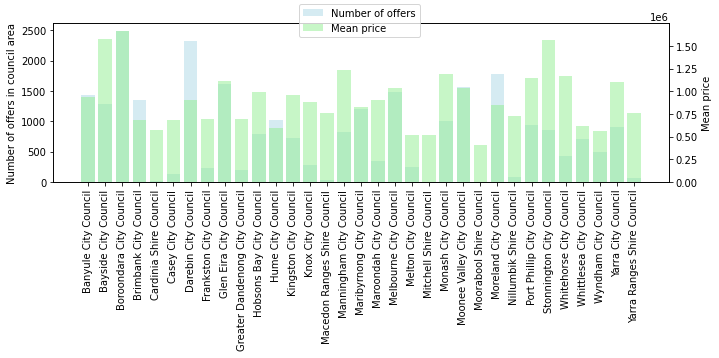

In [64]:
fig, ax1 = plt.subplots(figsize=(10,5))

# plotting council area number of offers
ax1.bar(council_grouped.index, council_grouped.CouncilArea, color='lightblue', alpha=0.5)
ax1.set_ylabel('Number of offers in council area')
ax1.set_xticklabels(rotation=90, labels=council_grouped.index)

# plotting mean price in council area
ax2 = ax1.twinx()
ax2.bar(council_grouped.index, council_grouped.Price, color='lightgreen', alpha=0.5)
ax2.set_ylabel('Mean price')

fig.tight_layout()
fig.legend(['Number of offers', 'Mean price'], loc='upper center')
plt.show()

The above plot shows that prices depend on council area. Even though plotting mean prices with line is not the perfect idea, it shows clearly what was mean price level. 

And that would be all for the initial data analysis. It was as quick as possible, just to make sure using variables as model features is reasonable. The next step will be feature creating - some of the columns has to be transformed so it can be proccessed by a model.

In [0]:
df.head()

,Suburb,Rooms,Type,Price,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,year_month
1,Abbotsford,2.0,h,1480000.0,BIGGIN,2016-03-12,2.5,3067,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,2016-03
2,Abbotsford,2.0,h,1035000.0,BIGGIN,2016-04-02,2.5,3067,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,2016-04
4,Abbotsford,3.0,h,1465000.0,BIGGIN,2017-04-03,2.5,3067,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,2017-04
5,Abbotsford,3.0,h,850000.0,BIGGIN,2017-04-03,2.5,3067,3.0,2.0,1.0,94.0,NaN,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,2017-04
6,Abbotsford,4.0,h,1600000.0,NELSON,2016-04-06,2.5,3067,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,2016-04


I am not saving the above subset of data, because the only thing I did was dropping some columns and this action should be taken in the next stage - feature creation. This however might be a good clue what to start with.